In [322]:
import warnings
import itertools
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import random
import sqlite3
from itertools import cycle, islice
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn import set_config
# Import timedelta from datetime library
from datetime import timedelta

# Model Selection / Grid Search libraries
from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.model_selection import GridSearchCV
ss = StandardScaler()

In [323]:
# Default settings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)
sns.set_style(style='whitegrid')

In [324]:
# ML models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

In [325]:
def WMAE(dataset, real, predicted):
    """
    Implementation of competition evaluation metric
    """
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [443]:
def print_correlation_matrix(df):
    """
    Default seaborn code to plot diagonal correlation matrix

    References:
    https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
    """
    corr = df.corr()
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
    plt.rcParams.update({'font.size': 9})
    plt.show()

In [327]:
def plot_regression_results(y_true, y_pred, title, scores):
    """
    Scatter plot of the predicted vs true targets
    """
    ax = plt.gca()
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc='w', fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)
    plt.show()

In [328]:
def plot_features_importance(importance, names, model_type):
    """
    This function plots the model features importance
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 7))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [329]:
def model_factory(model_type, **kwargs):
    """
    This function creates a model considering the model_type
    and specific arguments.

    Reference: https://medium.com/xp-inc/desing-patterns-factory-method-a7496ae071aa
    """
    # Specific for RandomForestRegressor or ExtraTreesRegressor
    if model_type in ['RandomForestRegressor', 'ExtraTreesRegressor'] :
        n_estimators = kwargs.get('n_estimators')
        verbose = kwargs.get('verbose')
        n_jobs = kwargs.get('n_jobs')

        if n_estimators is None:
            n_estimators = 50

        verbose = 0 if verbose is None else verbose

    if model_type == 'LinearRegression':
        return LinearRegression()
    elif model_type == 'KNN':
        return KNeighborsRegressor()
    elif model_type == 'Ridge':
        return RidgeCV()
    elif model_type == 'Lasso':
        return LassoCV()
    elif model_type == 'XGBRegressor':
        return XGBRegressor()
    elif model_type == 'RandomForestRegressor':
        return RandomForestRegressor(
            n_estimators = n_estimators,
            verbose = verbose,
            n_jobs = n_jobs
        )
    elif model_type == 'ExtraTreesRegressor':
        return ExtraTreesRegressor(
            n_estimators = n_estimators,
            verbose = verbose,
            n_jobs = n_jobs
        )
    else:
        raise ValueError('Model not defined on factory.')

#Importing Datasets

In [330]:
data = pd.read_csv('/content/train.csv')
stores = pd.read_csv('/content/stores.csv')
features = pd.read_csv('/content/features.csv')
test = pd.read_csv('/content/test.csv')

**Train Dataset**

This is the historical training data. Here are the fields:

1. Store - the store number
2. Dept - the department number
3. Date - the week
4. Weekly_Sales -  sales for the given department in the given store
5. IsHoliday - whether the week is a special holiday week

In [331]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [332]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


**Stores Dataset**

Containing anonymized information about the 45 stores, indicating the type and size of store.

In [333]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [334]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


**Features Dataset**

Containing additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

1. Store - the store number
2. Date - the week
3. Temperature - average temperature in the region
4. Fuel_Price - cost of fuel in the region
5. MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
5. CPI - the consumer price index
6. Unemployment - the unemployment rate
7. IsHoliday - whether the week is a special holiday week

In [335]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [336]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


#Handling Missing Values of Features Dataset

In [337]:
features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [338]:
percent_missing = features.isnull().sum() * 100 / len(features)
percent_missing

Store            0.000000
Date             0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       50.769231
MarkDown2       64.334554
MarkDown3       55.885226
MarkDown4       57.704518
MarkDown5       50.549451
CPI              7.142857
Unemployment     7.142857
IsHoliday        0.000000
dtype: float64

In [339]:
features["CPI"].fillna(features["CPI"].median(),inplace=True)
features["Unemployment"].fillna(features["Unemployment"].median(),inplace=True)

In [340]:
#Since there are a lot of missing values in MarkDown, I will fill the NA values with 0 and will decide whether to use MarkDown for modelling or discard MarkDown completely
for i in range(1,6):
  features["MarkDown"+str(i)].fillna(value=0,inplace=True)

In [341]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     8190 non-null   float64
 5   MarkDown2     8190 non-null   float64
 6   MarkDown3     8190 non-null   float64
 7   MarkDown4     8190 non-null   float64
 8   MarkDown5     8190 non-null   float64
 9   CPI           8190 non-null   float64
 10  Unemployment  8190 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


#Merging All Datasets

In [342]:
df = pd.merge(data,stores,on='Store',how='left')
df = pd.merge(df,features,on=['Store','Date'],how='left')

In [343]:
#Change the Date type
df['Date'] = pd.to_datetime(df['Date'])

In [344]:
#Sort the data by Date
df.sort_values(by=['Date'],inplace=True)
df.set_index(df.Date, inplace=True)

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     421570 non-null  float64       
 10  MarkDown2     421570 non-null  float64       
 11  MarkDown3     421570 non-null  float64       
 12  MarkDown4     421570 non-null  float64       
 13  MarkDown5     421570 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  U

In [346]:
#We only need 1 IsHoliday column, so we have to make sure if IsHoliday_x is the same as IsHoliday_y, if yes then we have to delete one of them
df['IsHoliday_x'].isin(df['IsHoliday_y']).all()

True

In [347]:
df.drop(columns='IsHoliday_x',inplace=True)
df.rename(columns={"IsHoliday_y" : "IsHoliday"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   Type          421570 non-null  object        
 5   Size          421570 non-null  int64         
 6   Temperature   421570 non-null  float64       
 7   Fuel_Price    421570 non-null  float64       
 8   MarkDown1     421570 non-null  float64       
 9   MarkDown2     421570 non-null  float64       
 10  MarkDown3     421570 non-null  float64       
 11  MarkDown4     421570 non-null  float64       
 12  MarkDown5     421570 non-null  float64       
 13  CPI           421570 non-null  float64       
 14  Unemployment  421570 non-null  float64       
 15  I

In [348]:
df.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False


#Duplicate Data

In [349]:
#Number of duplicated data
df.duplicated().sum()

0

# Splitting Date Column

In [350]:
df['Day']=df.Date.dt.day
df['Week']=df.Date.dt.isocalendar().week
df['Month']=df.Date.dt.month
df['Year']=df.Date.dt.year

In [351]:
df

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Day,Week,Month,Year
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False,5,5,2,2010
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.00,0.00,0.00,0.00,0.00,131.527903,10.064,False,5,5,2,2010
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.00,0.00,0.00,0.00,0.00,131.527903,10.064,False,5,5,2,2010
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.00,0.00,0.00,0.00,0.00,131.527903,10.064,False,5,5,2,2010
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.00,0.00,0.00,0.00,0.00,131.527903,10.064,False,5,5,2,2010
2010-02-05,2,49,2010-02-05,15767.00,A,202307,40.19,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,False,5,5,2,2010
2010-02-05,29,9,2010-02-05,4419.73,B,93638,24.36,2.788,0.00,0.00,0.00,0.00,0.00,131.527903,10.064,False,5,5,2,2010
2010-02-05,29,10,2010-02-05,7550.67,B,93638,24.36,2.788,0.00,0.00,0.00,0.00,0.00,131.527903,10.064,False,5,5,2,2010
2010-02-05,29,11,2010-02-05,6964.21,B,93638,24.36,2.788,0.00,0.00,0.00,0.00,0.00,131.527903,10.064,False,5,5,2,2010


#EDA

In [352]:
#Group column names based on type
numericals = ['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price',
                'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                'CPI', 'Unemployment','Day', 'Week','Month', 'Year'
                ]

categoricals = ['IsHoliday', 'Type','Date']

In [353]:
df[numericals].describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Day,Week,Month,Year
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.0,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,15.673131,25.826762,6.449510,2010.968591
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,8.753549,14.151887,3.243217,0.796876
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,1.000000,1.0,1.000000,2010.000000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,8.000000,14.0,4.000000,2010.000000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,16.000000,26.0,6.000000,2011.000000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,23.000000,38.0,9.000000,2012.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,31.000000,52.0,12.000000,2012.000000


Observation:

1.   The min.`Weekly_Sales` is negative. Possibly because there is a return but there is no sale/sales value is smaller than the value of the item being returned.
2.   There are also negative `MarkDowns`.
3. `Store`, `Dept`, and `Size` are discrete values. No need to infer the symmetry.
4. `Weekly_Sales`, `MarkDowns`, CPI columns have skewed distribution because there is quiet a difference between the mean and the median.



In [354]:
df[categoricals].describe()

,IsHoliday,Type,Date
count,421570,421570,421570
unique,2,3,143
top,False,A,2011-12-23 00:00:00
freq,391909,215478,3027
first,NaN,NaN,2010-02-05 00:00:00
last,NaN,NaN,2012-10-26 00:00:00


Observation:

1.   `IsHoliday` only has 2 values, "True" or "False".
2.   Most Walmart stores are Type A.
3. The dataset is historical data for 2 years and 9 months.

In [355]:
#Check whether these transactions reflect weekly/daily data
df['Date'].dt.day_name().unique()

array(['Friday'], dtype=object)

Observation:
Since the only unique day is Friday, it shows that this data reflects weekly transactions. Therefore, we can't perform the daily analysis.

##Univariate Analysis

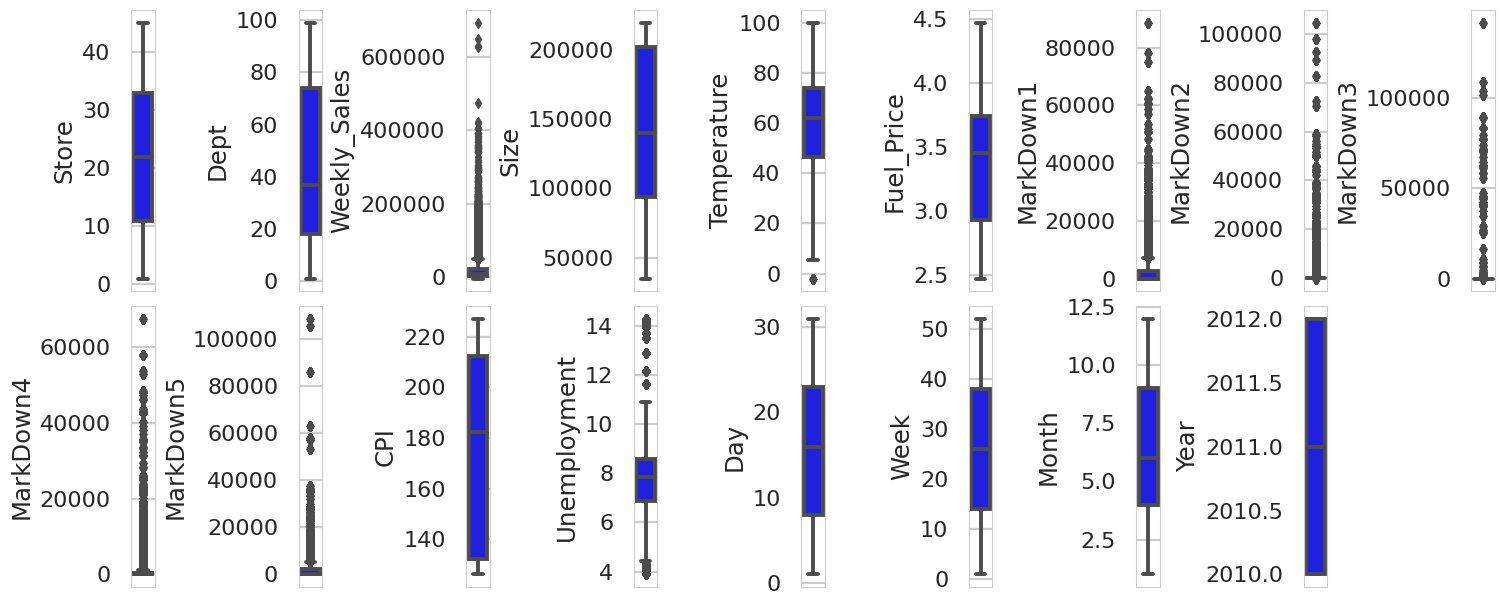

In [434]:
#Adjust the figure size for better readability
plt.figure(figsize=(15,6))

#Plotting
features_data = numericals
for i in range(0, len(features_data)):
  plt.subplot(2, len(features_data)//2 + 1, 1+i)
  sns.boxplot(y=df[features_data[i]], color='blue')
  plt.tight_layout()

In [357]:
Q1 = df[features_data].quantile(0.25)
Q3 = df[features_data].quantile(0.75)
IQR = Q3 - Q1
((df[features_data] < (Q1 - 1.5 * IQR)) | (df[features_data] > (Q3 + 1.5 * IQR))).sum()

Store                0
Dept                 0
Weekly_Sales     35521
Size                 0
Temperature         69
Fuel_Price           0
MarkDown1        55789
MarkDown2       103148
MarkDown3        84674
MarkDown4        79134
MarkDown5        40458
CPI                  0
Unemployment     32114
Day                  0
Week                 0
Month                0
Year                 0
dtype: int64

Observation:


1.   `MarkDowns` have so many outliers. Will determine later if it will be used for modelling.
2.   `Weekly_Sales` also have many outliers. But I think it's important to include them in the modelling.



##KDE plot for knowing the distribution form

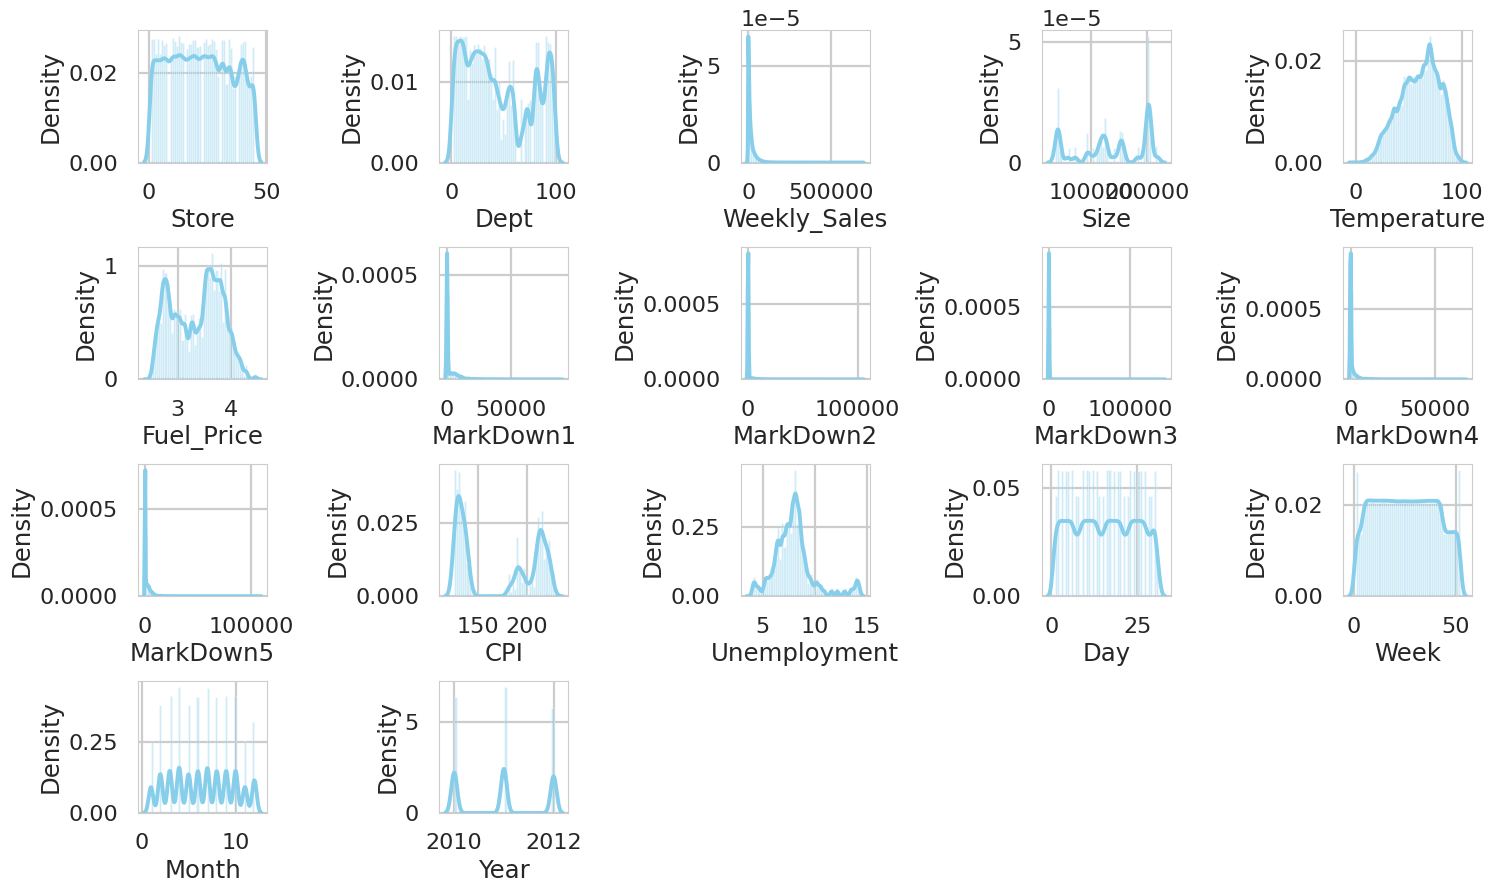

In [358]:
#Adjust the figure size for better readability
plt.figure(figsize=(15,9))

features_data = numericals
for i in range(0, len(features_data)):
    plt.subplot(4, len(features_data)//4 + 1, i+1)
    #plt.subplot(1, len(features_data), i+1)
    sns.distplot(x=df[features_data[i]], color='skyblue')
    plt.xlabel(features_data[i])
    plt.tight_layout()

Observation:
1. We can ignore interpreting feature columns with limited discrete values such as `Day`, `Week`, `Month`, `Year`, `Store`, `Dept`, `Size`
2. The true continuous numeric features: `Temperature`, `Fuel_Price`, and `Unemployment` are somewhat symmetric, which  is good (no need to transform them to approximate normal distribution). However, for `CPI`, it seems like it's bimodal distribution.
3. `MarkDowns` are positively skewed
4. In terms of the target variable, `Weekly_Sales` is positively skewed.

##Multivariate Analysis

###Sales vs Markdown

In [359]:
import plotly.graph_objs as go
from plotly import tools
df_weeks = df.groupby('Week').sum()
fig = go.Figure()

fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['Weekly_Sales'], name = 'Weekly Sales', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )

fig.update_layout(title = 'Sales vs Markdown', xaxis_title = 'Weeks')

###Average Monthly Sales

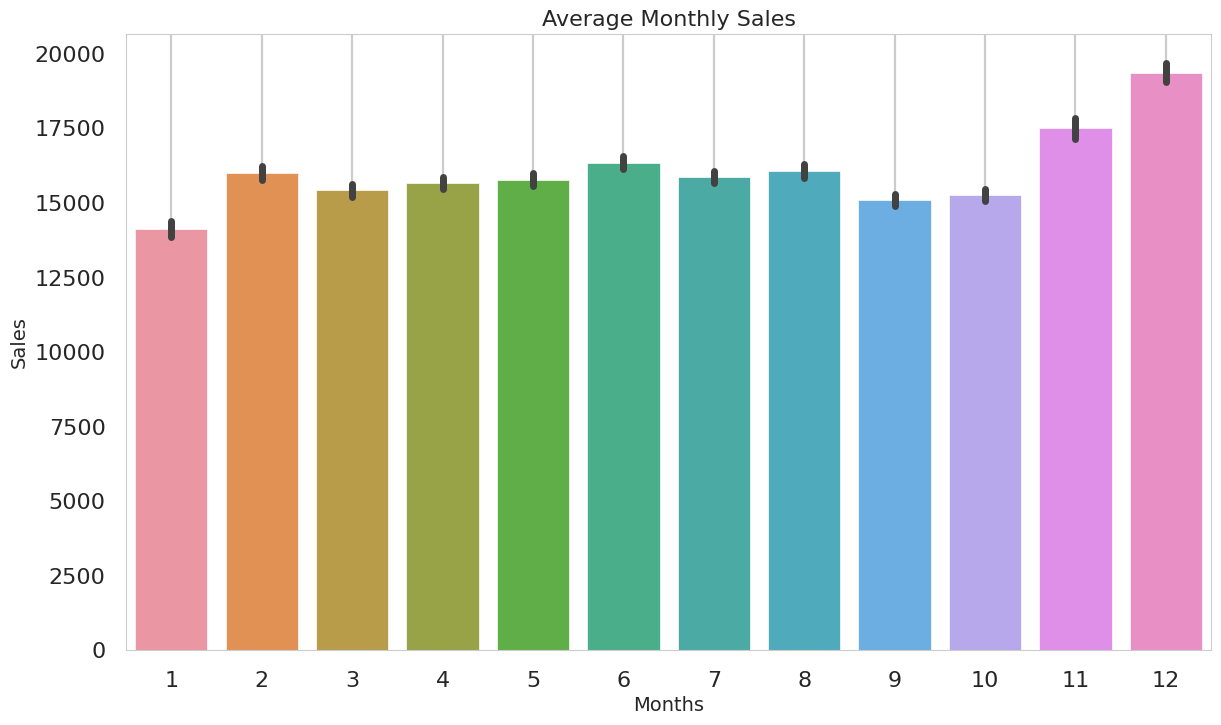

In [360]:
plt.figure(figsize=(14,8))
sns.barplot(x='Month',y='Weekly_Sales',data=df)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Months',fontsize=14)
plt.title('Average Monthly Sales',fontsize=16)
plt.grid()

###Monthly Sales for Each Year

In [361]:
df_monthly = pd.crosstab(df["Month"], df["Year"], values=df["Weekly_Sales"],aggfunc='sum')
df_monthly

Year,2010,2011,2012
Month,,,
1,NaN,1.637040e+08,1.688945e+08
2,1.903330e+08,1.863313e+08,1.920636e+08
3,1.819198e+08,1.793564e+08,2.315097e+08
4,2.314124e+08,2.265265e+08,1.889209e+08
5,1.867109e+08,1.816482e+08,1.887665e+08
6,1.922462e+08,1.897734e+08,2.406103e+08
7,2.325801e+08,2.299114e+08,1.875095e+08
8,1.876401e+08,1.885993e+08,2.368508e+08
9,1.772679e+08,2.208477e+08,1.806455e+08


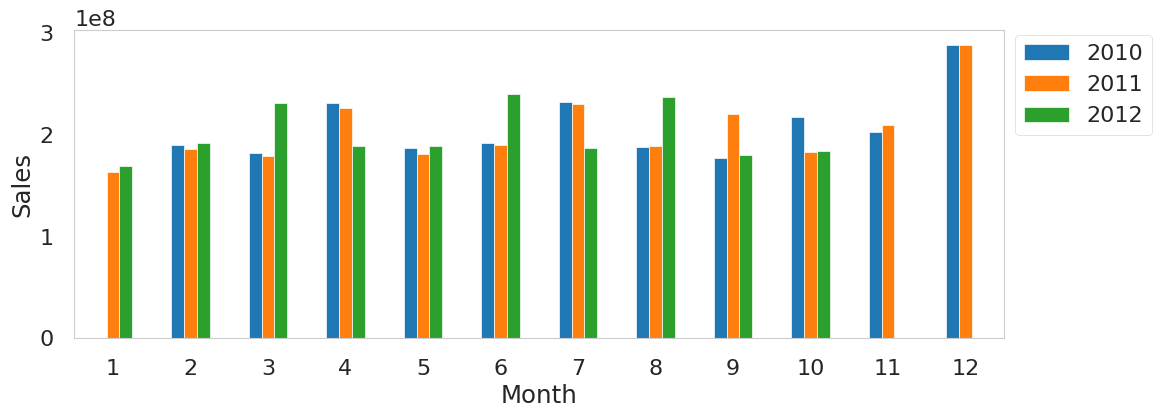

In [362]:
ax = df_monthly.plot(kind='bar', figsize=(12, 4), ylabel='Sales', xlabel='Month', rot=0)
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.grid()

Observation:


1.   Sales trends in February, November and December each year are not much different. This is because Super Bowl in February, Black Friday and Thanksgiving in November, Christmas in December.
2.   Sales trend in May is also not much different each year.



###Holiday vs Not-Holiday

There are 4 holidays in the dataset:
1. Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
2. Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
3. Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
4. Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

I want to see differences between holiday types.

In [363]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [364]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [365]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [366]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

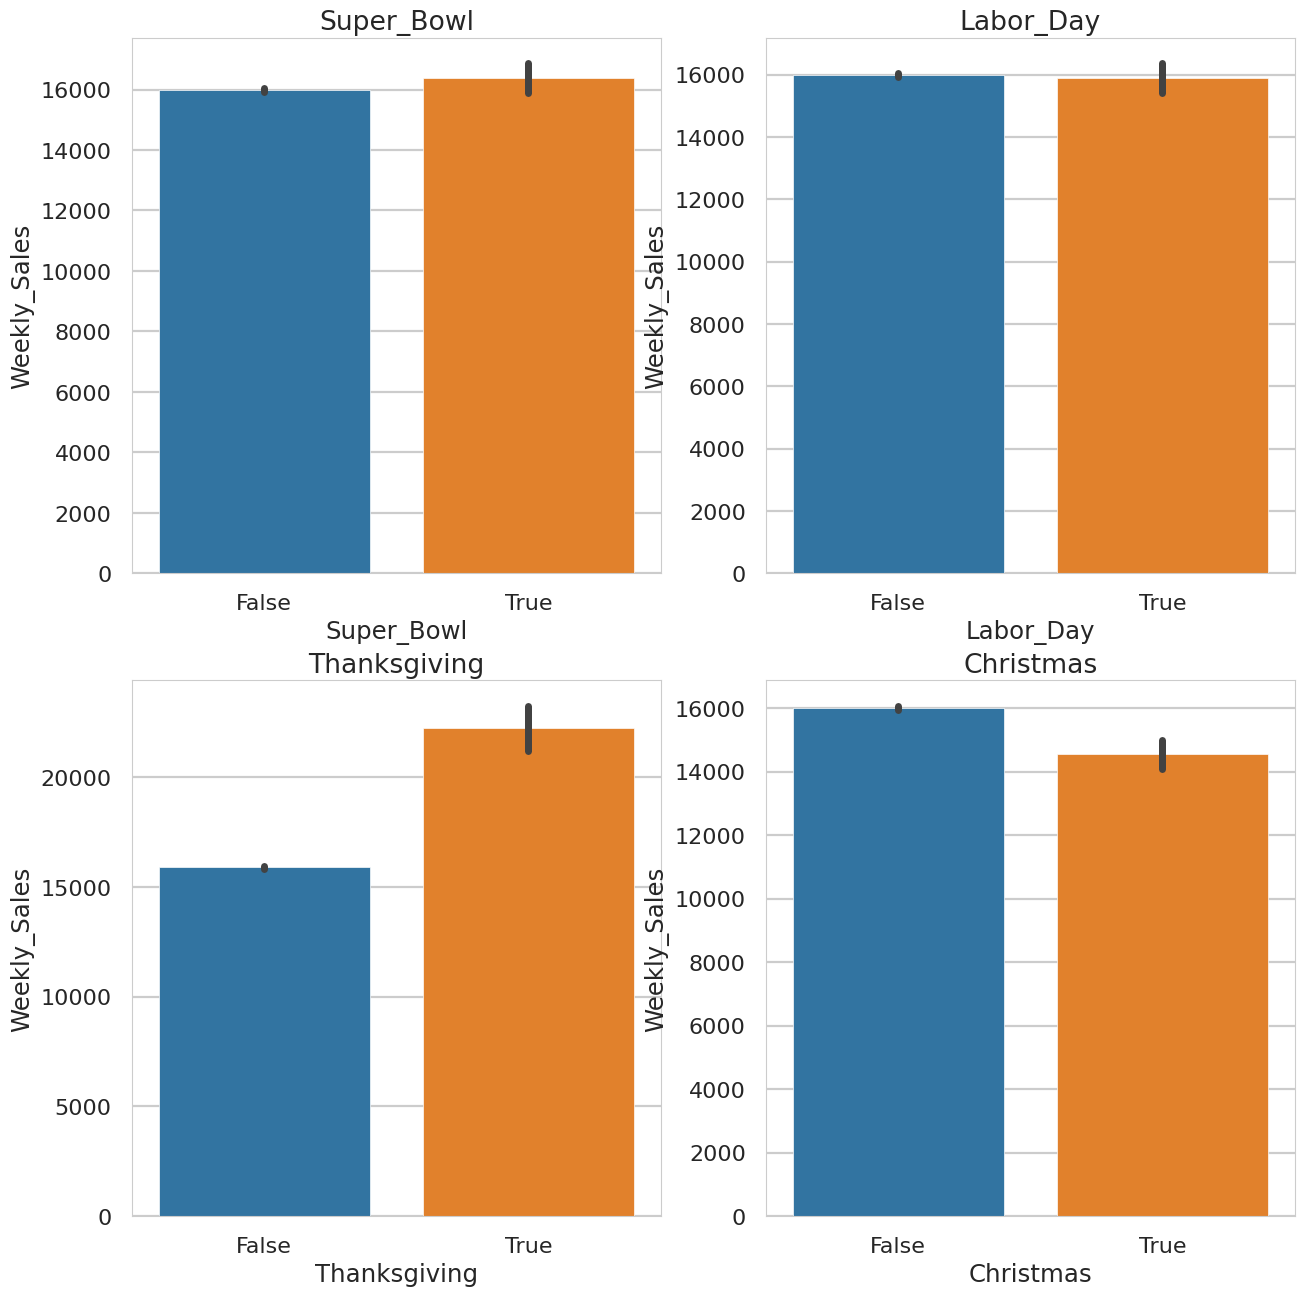

In [437]:
#Holiday vs not-Holiday
cols = ['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas']
plt.figure(figsize=(15,32))
plt.rcParams.update({'font.size': 9})

for i, col in enumerate(cols):
    ax = plt.subplot(len(cols), 2, i+1)
    sns.barplot(x=str(col), y='Weekly_Sales', data=df)
    ax.set_title(f"{col}")

Observation: There is a significantly positive effect on sales in Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

###Percentages of Store Types

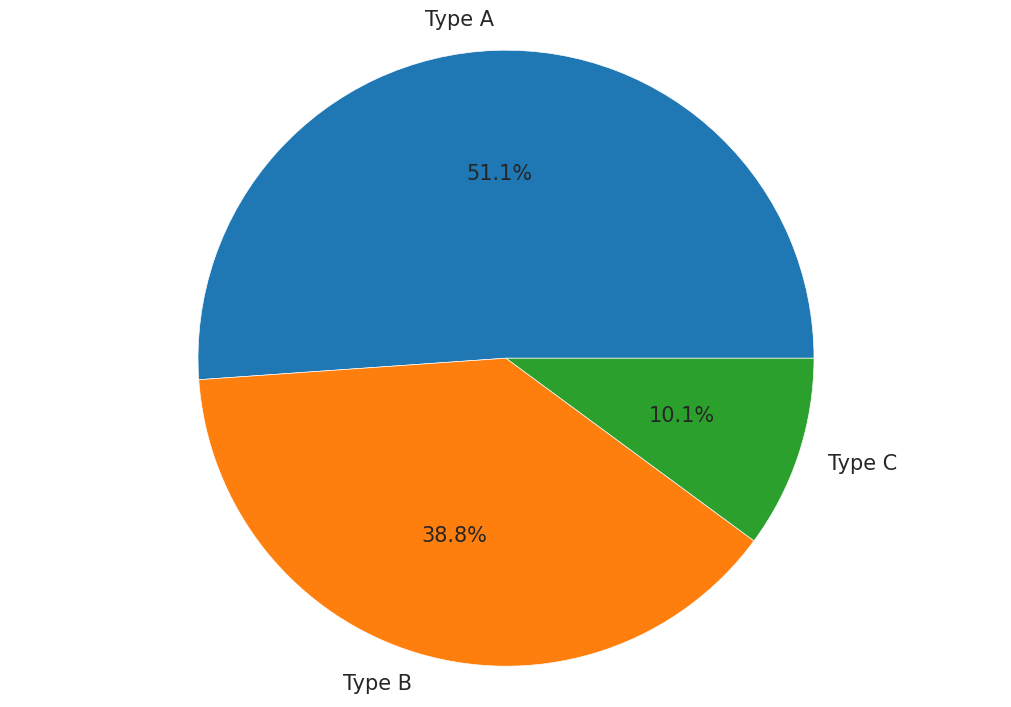

In [368]:
import matplotlib as mpl

A = df.Type[df.Type=='A'].count()/df.Type.count()*100
B = df.Type[df.Type=='B'].count()/df.Type.count()*100
C = df.Type[df.Type=='C'].count()/df.Type.count()*100

my_data = [A, B, C]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

###Store Type Effect on Holidays

In [369]:
C_mean = df.groupby(['Christmas','Type'])['Weekly_Sales'].mean().apply(lambda x: round(x, 2))  # Avg weekly sales for types on Christmas
C_mean

Christmas  Type
False      A       20126.30
           B       12249.15
           C        9541.69
True       A       18231.03
           B       11394.05
           C        7963.23
Name: Weekly_Sales, dtype: float64

In [370]:
L_mean = df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean().apply(lambda x: round(x, 2))  # Avg weekly sales for types on Labor Day
L_mean

Labor_Day  Type
False      A       20102.29
           B       12241.86
           C        9512.02
True       A       19973.22
           B       12013.48
           C        9871.23
Name: Weekly_Sales, dtype: float64

In [371]:
T_mean = df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean().apply(lambda x: round(x, 2))  # Avg weekly sales for types on Thanksgiving
T_mean

Thanksgiving  Type
False         A       19995.31
              B       12144.56
              C        9517.27
True          A       27370.73
              B       18661.30
              C        9679.90
Name: Weekly_Sales, dtype: float64

In [372]:
S_mean = df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean().apply(lambda x: round(x, 2))  # Avg weekly sales for types on Super Bowl
S_mean

Super_Bowl  Type
False       A       20088.68
            B       12233.52
            C        9506.06
True        A       20603.69
            B       12401.72
            C       10156.20
Name: Weekly_Sales, dtype: float64

In [373]:
Holiday_mean = df.groupby('IsHoliday')['Weekly_Sales'].mean().apply(lambda x: round(x, 2))
Holiday_mean

IsHoliday
False    15901.45
True     17035.82
Name: Weekly_Sales, dtype: float64

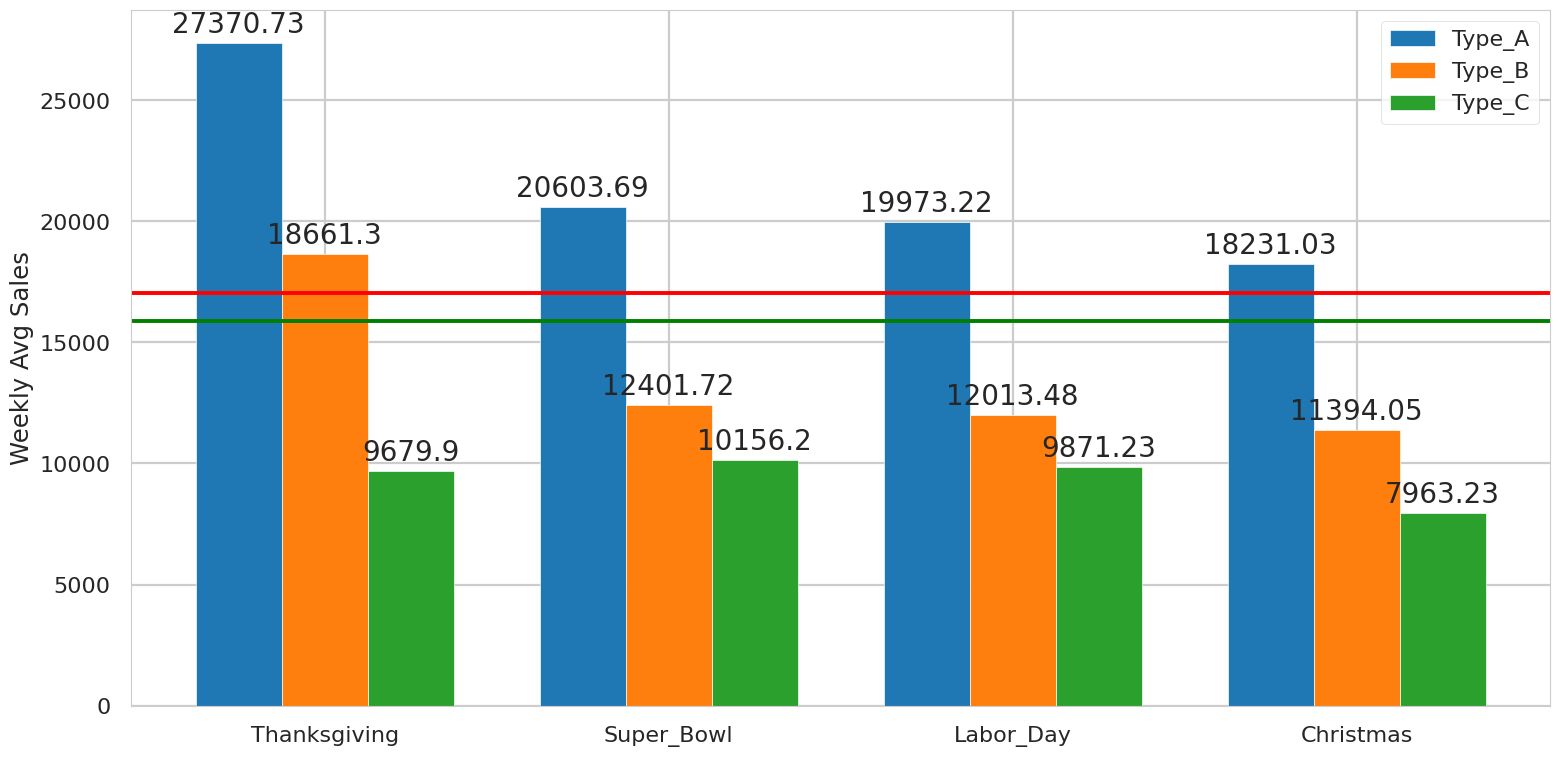

In [374]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [T_mean[3], S_mean[3], L_mean[3], C_mean[3]]
B_means = [T_mean[4], S_mean[4], L_mean[4], C_mean[4]]
C_means = [T_mean[5], S_mean[5], L_mean[5], C_mean[5]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=Holiday_mean[1],color='r') # holidays avg
plt.axhline(y=Holiday_mean[0],color='green') # not-holiday avg

fig.tight_layout()

plt.show()

Observation: It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

In [375]:
# create dummy variables for 'Type' and keeping all columns to see heatmap then will drop 1 column
Type_dummies = pd.get_dummies(df.Type, prefix='Type')

# concatenate two DataFrames (axis=0 for rows, axis=1 for columns)
df_2 = pd.concat([df, Type_dummies], axis=1)

# Not dropping the orginal Type column now so that I can use the field in some data analysis

In [444]:
#Create a dataframe for heatmap
data_heatmap_df=df.copy()

# Eliminating all the columns that are not continuous/binary  variables from the heatmap section.
data_heatmap_df.drop(['Store','Day','Month','Year','Date','Store','Type'], axis=1,inplace=True)


# Lets look the correlation matrix and heat map of the

## Correlation Heat map
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,8))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap='Pastel1_r')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=9, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=9, rotation=0)


    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

###Time Series Decomposition

Time series decomposition helps to deconstruct the time series into several component like trend and seasonality for better visualization of its characteristics. Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data

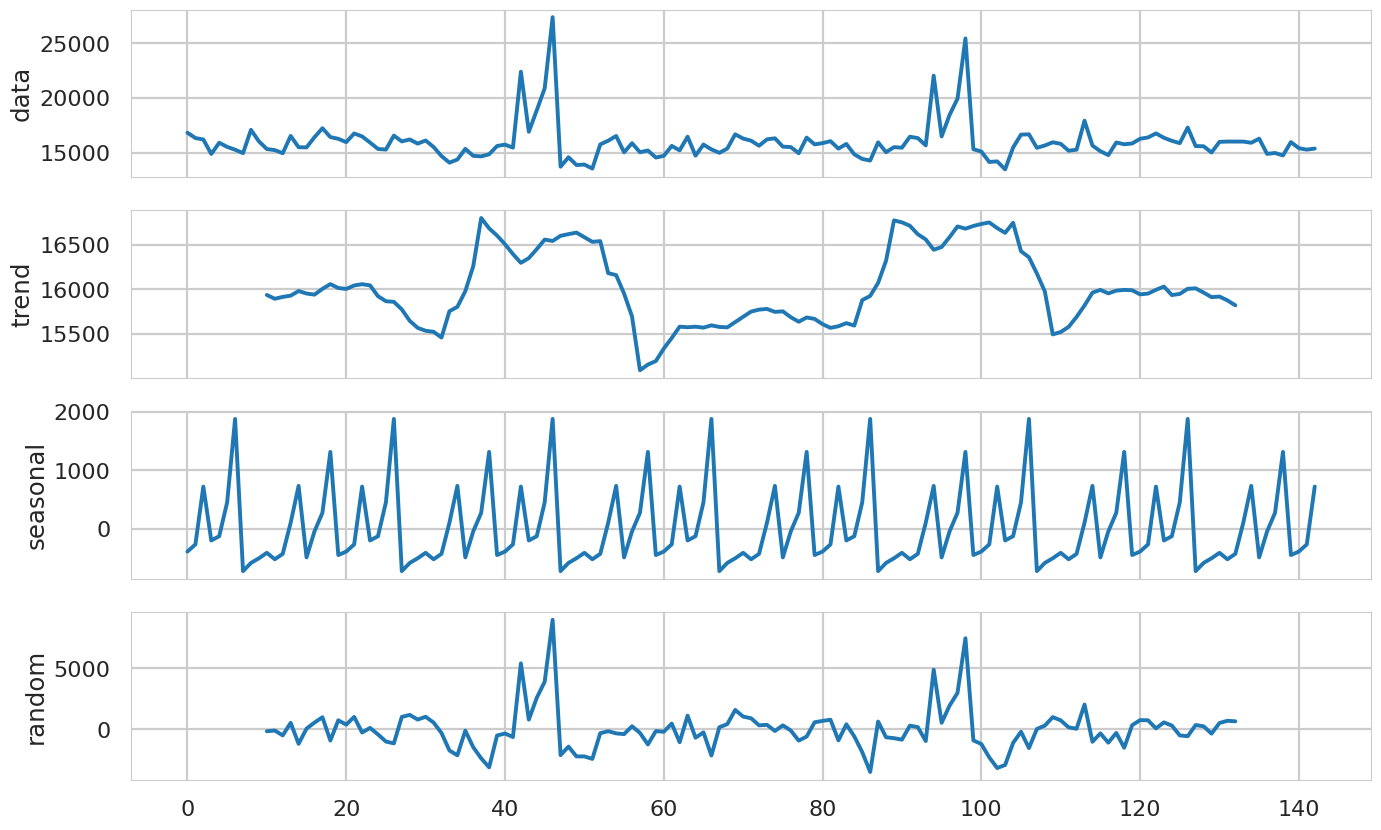

In [377]:
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima
df_week = df.resample('W').mean() #resample data as weekly
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point.

There's a strong seasonal behavior. They seem to happen in the same period

###Correlation Matrix

In [447]:
def print_correlation_matrix(df):
    """
    Default seaborn code to plot diagonal correlation matrix

    References:
    https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
    """
    corr = df.corr()
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
    plt.rcParams.update({'font.size': 9})
    plt.show()

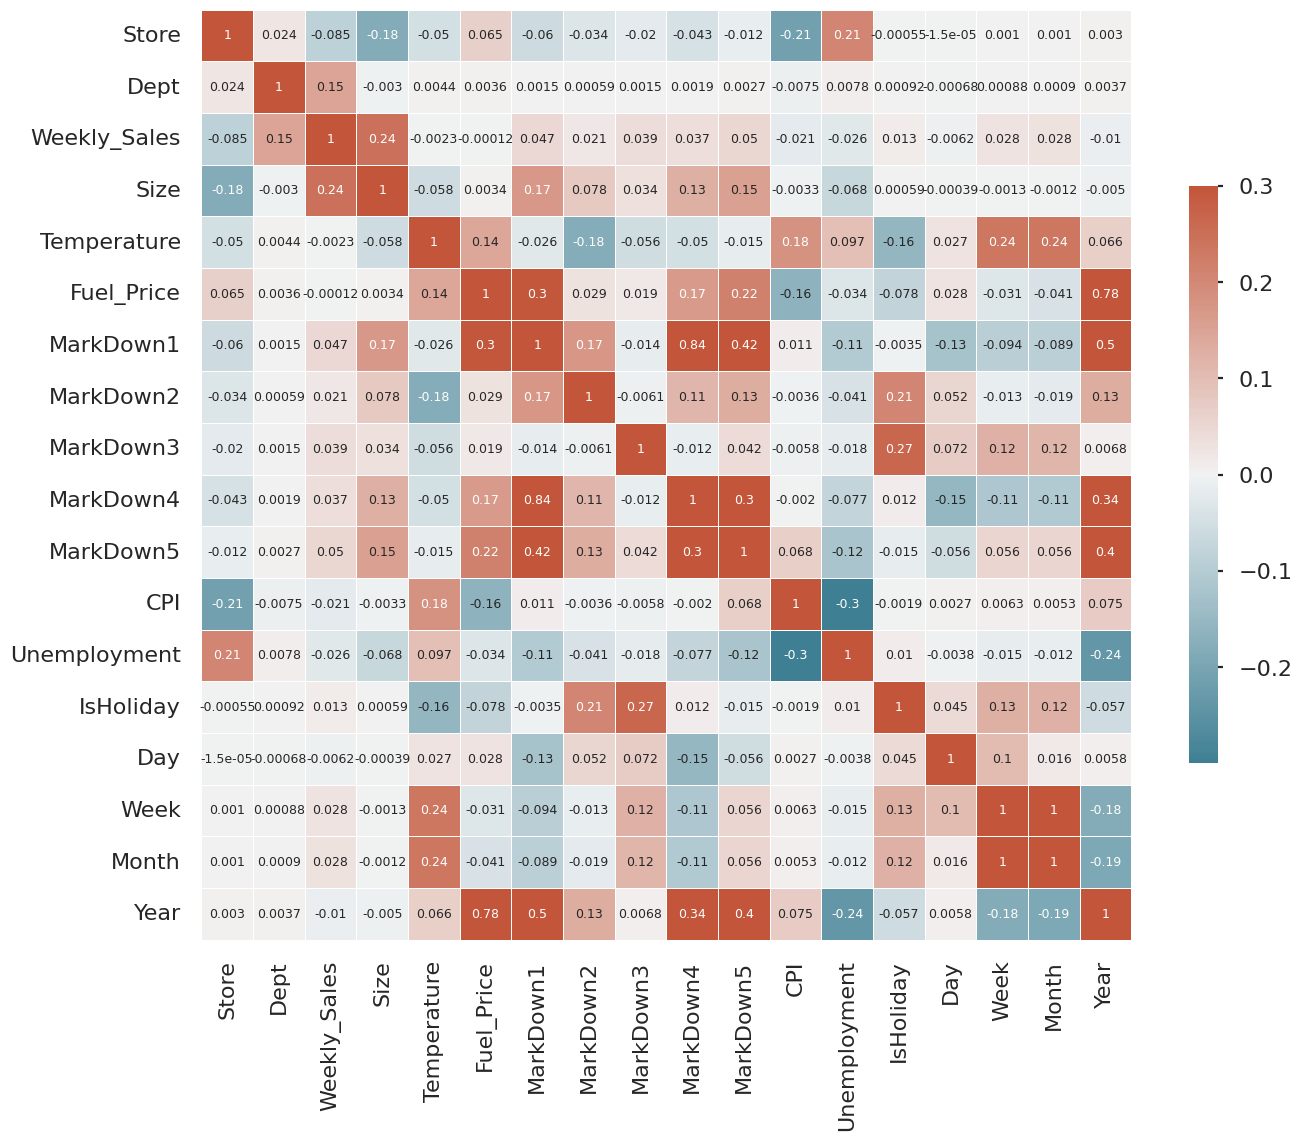

In [448]:
# Plotting the correlation matrix. Here I will check for relations with the Weekly Sales feature
print_correlation_matrix(df)

When we look at the correlation matrix, we can see that `Weekly_Sales` have a higher correlation ( abs(corr)>0.05) with:

*   `Store`
*   `Dept`
*   `Size`

This is a really important insight because, as we know, being able to correctly predict weekly sales on Holidays is extremely important. However, the correlation between `IsHoliday` and `Weekly_Sales` has a lower value (0.013).

Despite having a low correlation, we need to remember that this feature only happens 4 times a year besides being a really important one considering our problem. Considering it, we will also need to check for other ways to explain time-related features to the model. `IsHoliday` feature may not be enough to explain every sales behavior.

####Dropping features with lower correlation

Additional info: We can drop some features here since most of the MarkDown columns are not available and in this case, Walmart specified that those values are not consistent since we don't have them for every store all the time. MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
Reference: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

In [380]:
df_train = df.copy()
df_train.drop(['Temperature', 'Fuel_Price', 'Unemployment', 'CPI','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1, inplace=True)

In [381]:
#Also drop the columns that are used for visualization
df_train.drop(['Super_Bowl', 'Labor_Day', 'Thanksgiving','Christmas'], axis=1, inplace=True)
df_train

,Store,Dept,Date,Weekly_Sales,Type,Size,IsHoliday,Day,Week,Month,Year
Date,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,False,5,5,2,2010
2010-02-05,29,5,2010-02-05,15552.08,B,93638,False,5,5,2,2010
2010-02-05,29,6,2010-02-05,3200.22,B,93638,False,5,5,2,2010
2010-02-05,29,7,2010-02-05,10820.05,B,93638,False,5,5,2,2010
2010-02-05,29,8,2010-02-05,20055.64,B,93638,False,5,5,2,2010
2010-02-05,2,49,2010-02-05,15767.00,A,202307,False,5,5,2,2010
2010-02-05,29,9,2010-02-05,4419.73,B,93638,False,5,5,2,2010
2010-02-05,29,10,2010-02-05,7550.67,B,93638,False,5,5,2,2010
2010-02-05,29,11,2010-02-05,6964.21,B,93638,False,5,5,2,2010


#Feature Engineering

Add `HolidayType` column:
[-1 = No Holiday, 0 = Super Bowl, 1 = Labor Day, 2 = Thanksgiving, 3 = Christmas]

In [382]:
def create_features(df):
    """
    This function creates the following features: Week, Month, Year and
    HolidayType
    """
    def create_holiday_type_column(df, dates, holiday_type, name):
        df.loc[
            df['Date'].isin(dates),
            'HolidayType'
        ] = holiday_type

    df['HolidayType'] = -1

    holiday_list = [
        (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'], 'Super_Bowl'),
        (['2010-09-10','2011-09-09', '2012-09-07', '2013-09-06'], 'Labor_Day'),
        (['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'], 'Thanksgiving'),
        (['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 'Christmas')
    ]

    for index in range(0, len(holiday_list)):
        holiday = holiday_list[index]
        create_holiday_type_column(df, holiday[0], index, holiday[1])

    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.week
    df['Year'] =  df.Date.dt.year
    df['Month'] =  df.Date.dt.month

    # Convert all columns to float
    for x in df:
        if df[x].dtypes == "int64":
            df[x] = df[x].astype(float)

In [383]:
create_features(df_train)

#Preprocessing

1. Transform all categorical features into ordinal categories using OrdinalEncoder. Here, we use this transformation for the column `Type`.
2. Standardize numerical features by removing the mean and scaling to unit variance using StandardScaler.

In [384]:
# Divide dataset for training
X = df_train.drop(['Weekly_Sales', 'Date'], axis=1)
y = df_train['Weekly_Sales']

In [385]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer

categorical_features = X.columns[X.dtypes == 'O']
numeric_features = X.columns[X.dtypes == 'float64']

categories = [X[column].unique() for column in X[categorical_features]]
for cat in categories:
    cat[cat == None] = 'missing'

transform_categorical_features = make_pipeline(
    # Fill all NaN values to missing
    SimpleImputer(missing_values=None,
                  strategy='constant',
                  fill_value='missing'),
    # Transform categorical features into ordinal categories
    OrdinalEncoder(categories=categories)
)

transform_numeric_features = make_pipeline(
    # Fill all NaN values to -1
    SimpleImputer(strategy='constant', fill_value=-9999),
    # Standardize features by removing the mean and scaling to unit variance
    StandardScaler()
)

# Pre-processing transformation
preprocessing_step = make_column_transformer(
    (transform_categorical_features, categorical_features),
    (transform_numeric_features, numeric_features),
    remainder='passthrough'
)

#Training

Training step can be divided into 3 major steps:

1. Step 1: Find the best ML model type
2. Step 2: Find the best hyperparameter combination
3. Step 3: Training the full dataset considering the best model type and hyperparameter combination

To avoid overfitting in every step of the training pipeline, I used train_test_split function with a test_size of 0.2 since this is a common value used in literature.

In [386]:
# Divide dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

##Step 1: Find the best ML model type

In this section, I used some regression models to find the better one considering WMAE evaluation on hyperparameter combination.

The following regression models were tested: Linear Regression, KNN, Ridge, Lasso, XGBRegressor, RandomForestRegressor, and ExtraTreesRegressor

To avoid overfitting and have a better view of the models' behavior on different datasets, I used a cross validation strategy, considering 3 folds. The better model will be the one with the lowest WMA.

In [387]:
import math

regression_models = [
    'LinearRegression',
    'KNN',
    'Ridge',
    'Lasso',
    'XGBRegressor',
    'RandomForestRegressor',
    'ExtraTreesRegressor'
]

best_model = None
best_error = math.inf

--------------------------------------------------
Training evaluation
--------------------------------------------------
:: LinearRegression - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished


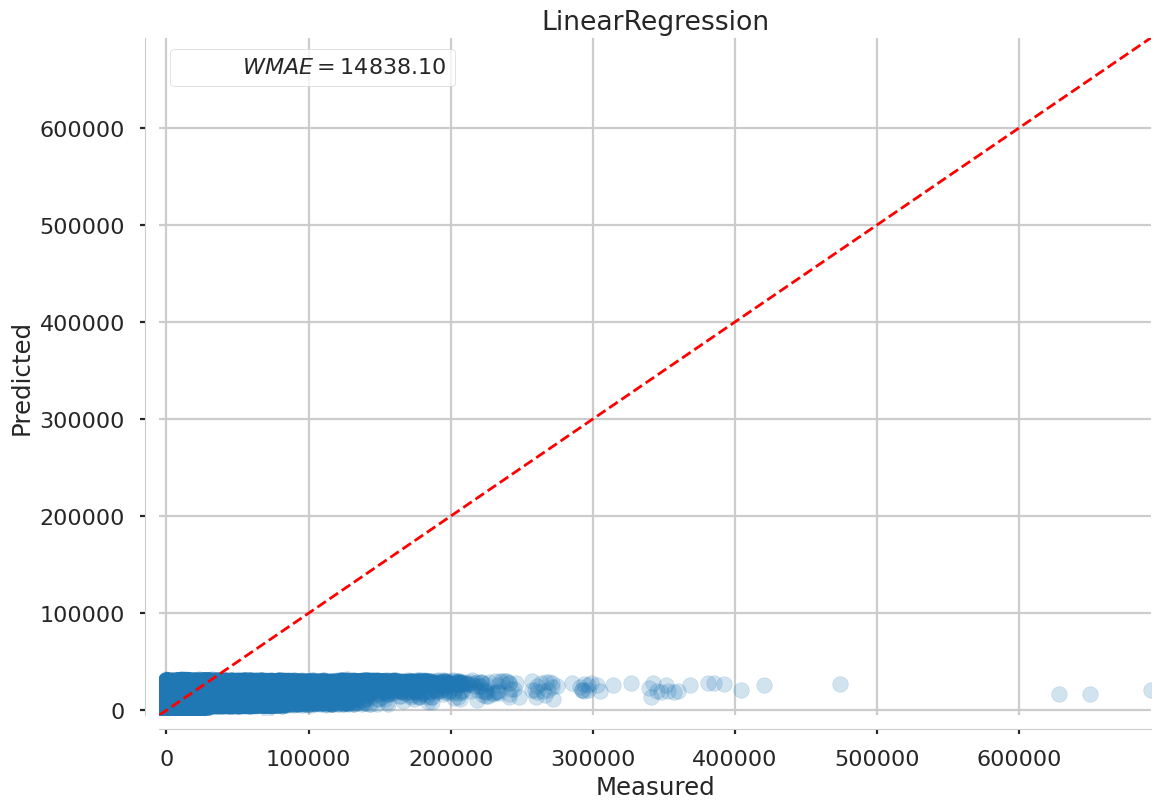

--------------------------------------------------
:: KNN - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.4s finished


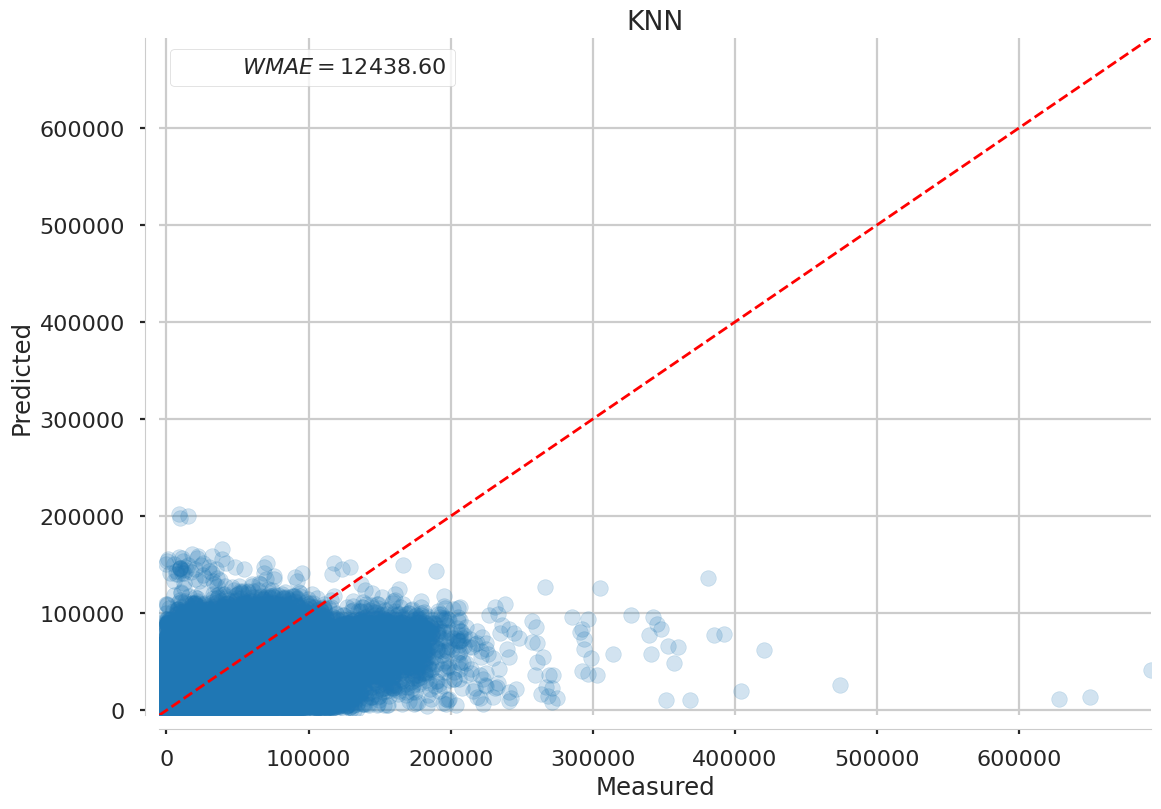

--------------------------------------------------
:: Ridge - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


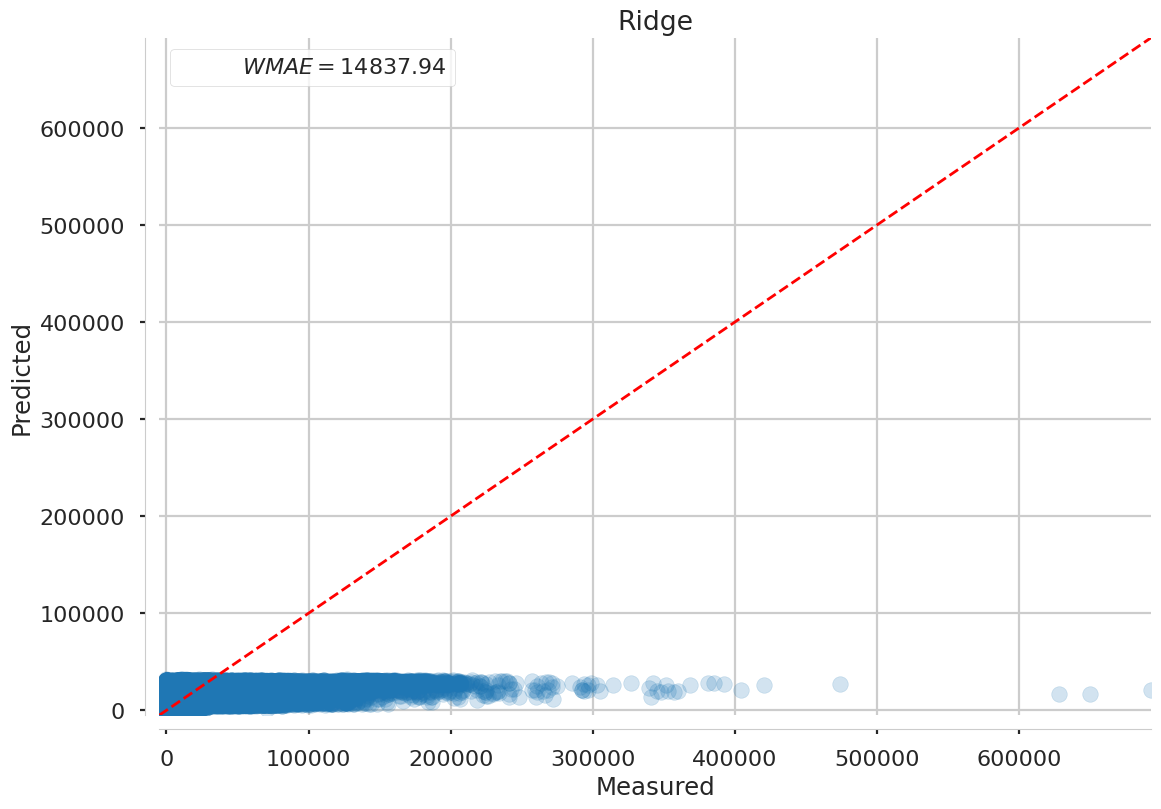

--------------------------------------------------
:: Lasso - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


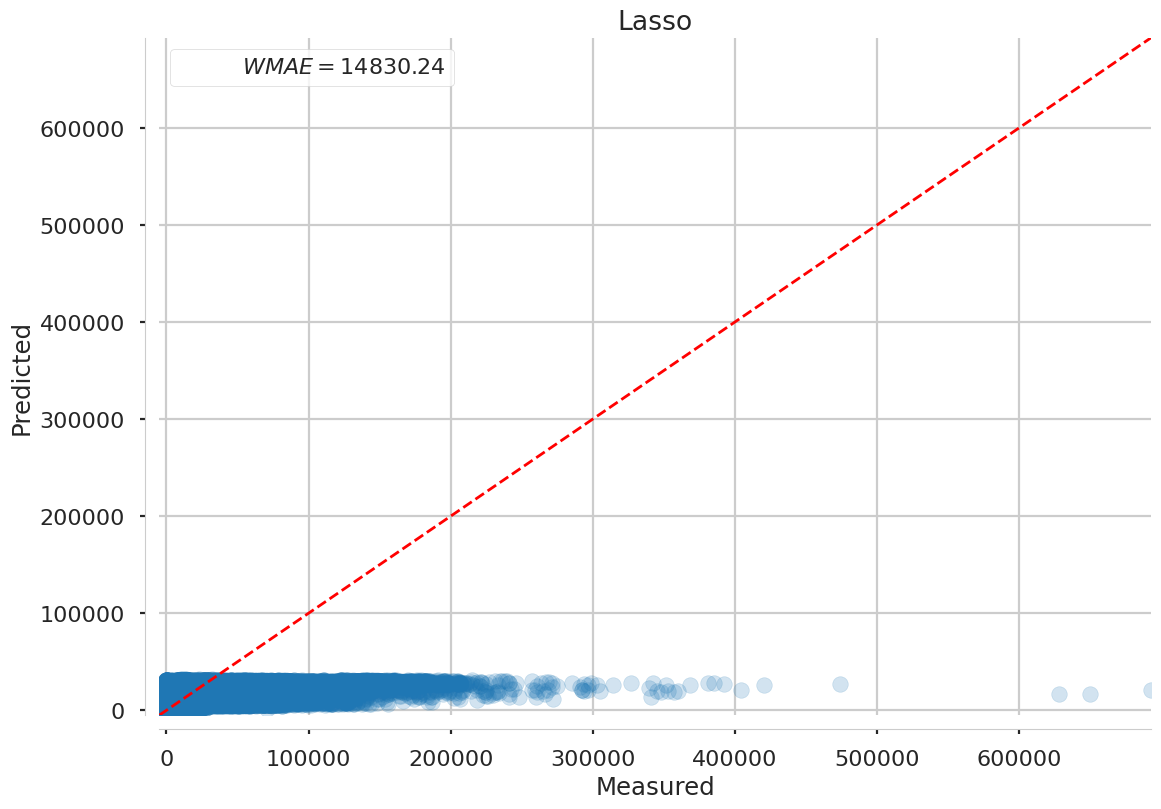

--------------------------------------------------
:: XGBRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.5s finished


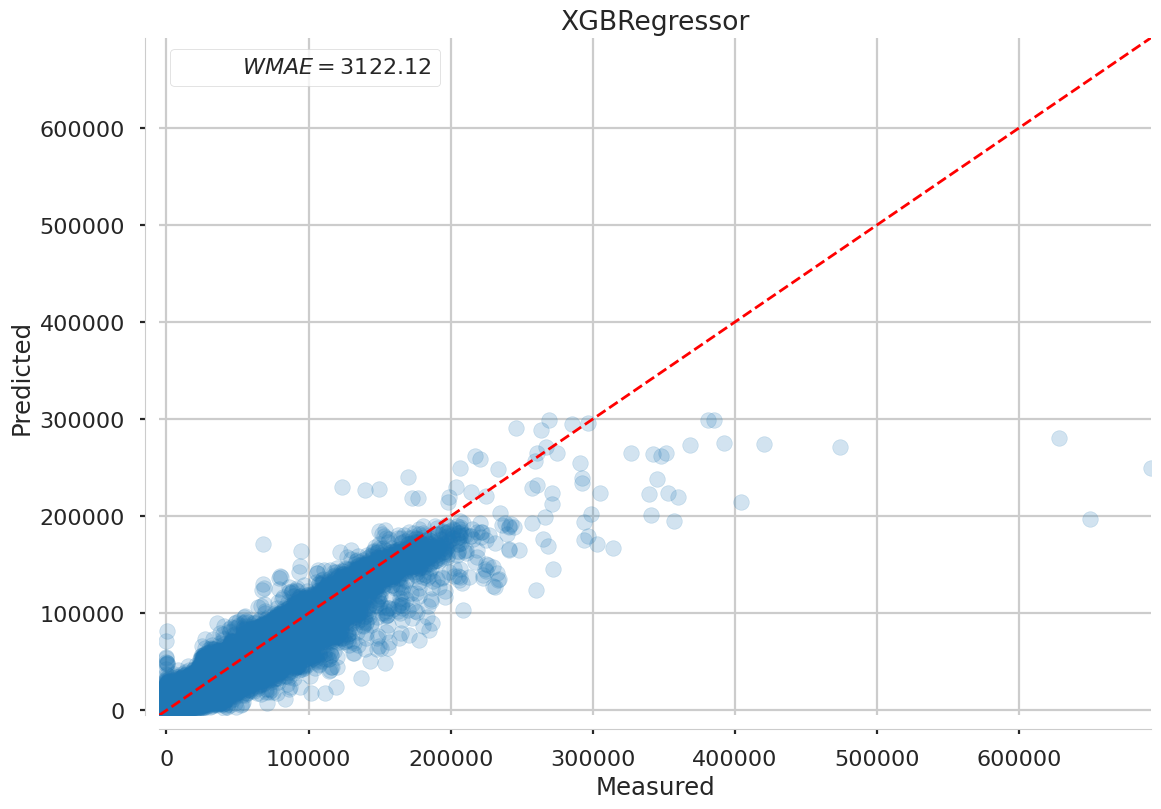

--------------------------------------------------
:: RandomForestRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


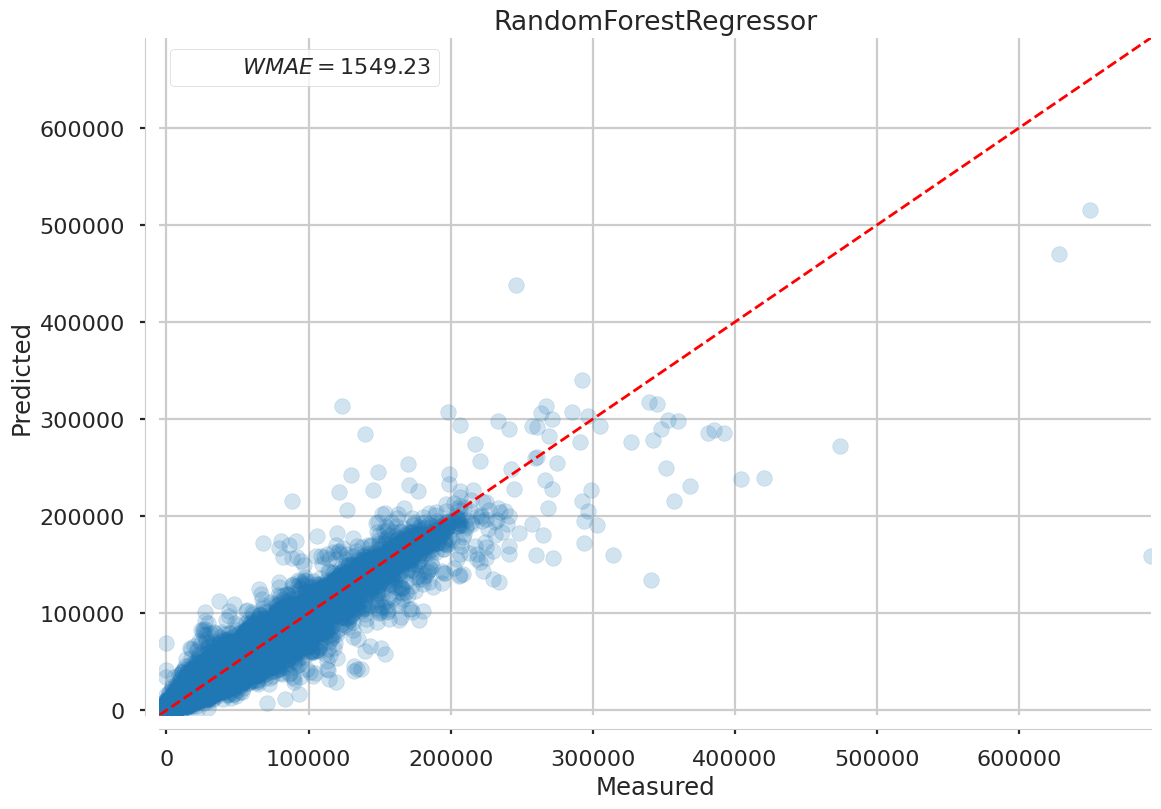

--------------------------------------------------
:: ExtraTreesRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.9s finished


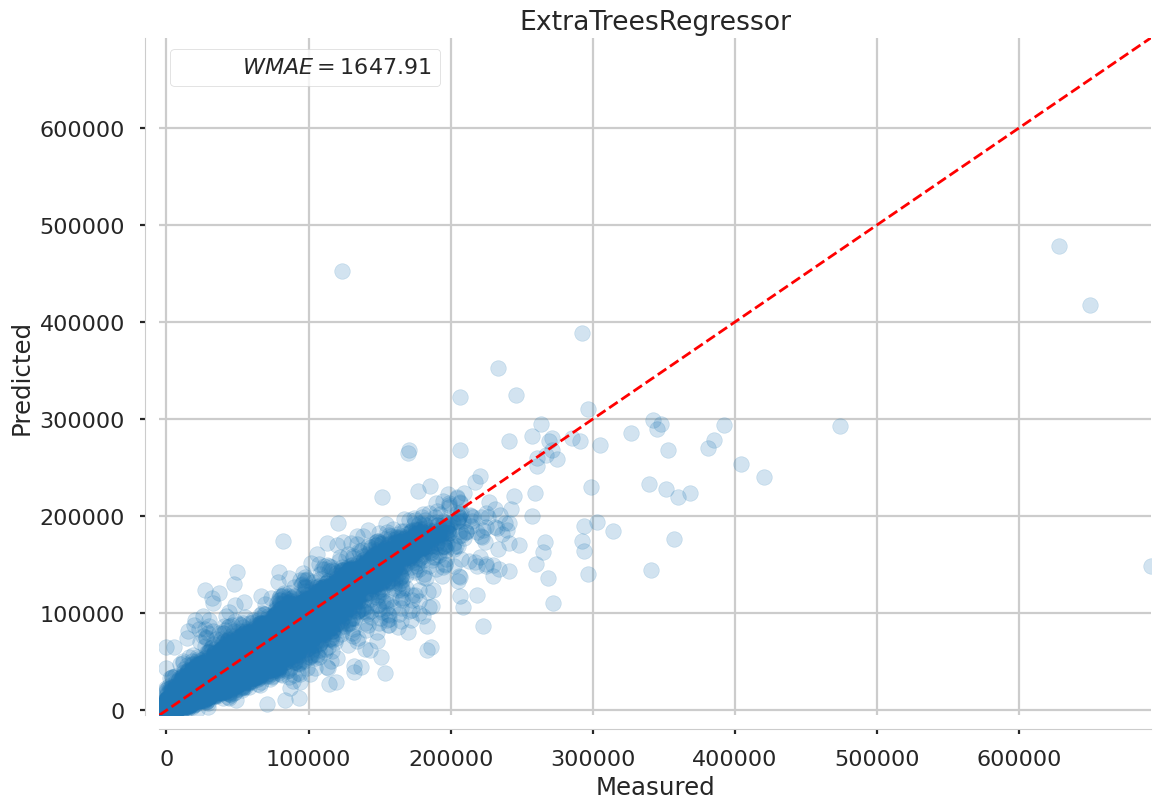

--------------------------------------------------


In [388]:
print('-' * 50)
print('Training evaluation')
print('-' * 50)

for name in regression_models:
    # Create a basic pipeline
    print(f':: {name} - Training Pipeline')
    regressor = model_factory(name)
    training_pipeline = make_pipeline(
        preprocessing_step,
        regressor
    )

    kfold = KFold(n_splits=3)

    y_pred = cross_val_predict(
        training_pipeline,
        X_train,
        y_train,
        cv = kfold,
        n_jobs = -1,
        verbose = 1
    )

    wmae_metric = WMAE(X_train, y_train, y_pred)

    if wmae_metric < best_error:
        best_error = wmae_metric
        best_model = name

    plot_regression_results(
        y_train,
        y_pred,
        name,
        (r'$WMAE ={:.2f}$').format(wmae_metric)
    )

    print('-' * 50)

In [389]:
print(f'Best model is {best_model}')
print(f'Best score is {best_error}')

Best model is RandomForestRegressor
Best score is 1549.23


##Step 2: Find the best hyperparameter combination

After finding the best model, we need to find the best combination of hyperparameters. For simplicity's sake, this step was only implemented for the two models with the lowest on Step 1: ExtraTreesRegressor and RandomForestRegressor.

I'm also using all default model options except for n_estimators, since this feature has a huge impact on the final result.

n_estimators: The number of trees in the forest.

The strategy used here is finding the best hyperparameter combination using GridSearchCV approach.

In [390]:
# The number of trees in the forest
n_estimators = [x for x in range(50, 250, 50)]

# Create the random grid
random_grid = {
    'model__n_estimators': n_estimators
}

random_grid

{'model__n_estimators': [50, 100, 150, 200]}

In [391]:
def get_best_model_parameters(random_grid, X, y):
    if best_model in ['ExtraTreesRegressor', 'RandomForestRegressor']:
        model = model_factory(best_model)
    else:
        # grid search not implemented for other models
        return {'model__n_estimators': None}

    grid_pipeline =  Pipeline(
        [("preprocessing", preprocessing_step),
         ("model", model)]
    )

    kfold = KFold(n_splits=3)

    model_random = GridSearchCV(
        grid_pipeline,
        param_grid = random_grid,
        cv = kfold,
        verbose = 2,
        n_jobs = -1
    )

    # Create a sample to speed up parameter search
    X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.9)
    return model_random.fit(X_sample, y_sample).best_params_

# Best Parameter combination
best_params = get_best_model_parameters(random_grid, X, y)
best_params

Fitting 3 folds for each of 4 candidates, totalling 12 fits


{'model__n_estimators': 200}

##Step 3: Training the full dataset

This step trains a model considering the best model type and hyperparameter combination found on the steps before. Here, I also plotted some graphs and the whole pipeline schema to have a better view of our results and training metrics.

In [392]:
print('-' * 70)
print(f'Best Model: {best_model}: {best_params}\n')
print('Tip: click on the Pipeline diagram below to have a better view of each step.')
print('-' * 70)

model = model_factory(
    best_model,
    n_estimators = best_params['model__n_estimators'],
    verbose = 1,
    n_jobs = -1
)

best_model_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing_step),
        ("model", model)
    ]
)

set_config(display='diagram')
best_model_pipeline.fit(X_train, y_train)

----------------------------------------------------------------------
Best Model: RandomForestRegressor: {'model__n_estimators': 200}

Tip: click on the Pipeline diagram below to have a better view of each step.
----------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 missing_values=None,
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['A', 'B', 'C'], dtype=object)]))]),
                                                  Index(['Type'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=-9999,
                                                                                 strategy='constant')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Store', 'Dept', 'Size', 'Day', 'Week', 'Month', 'Year', 'HolidayType'], dtype='object'))])),
                ('model',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       verbose=1))])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.2s finished


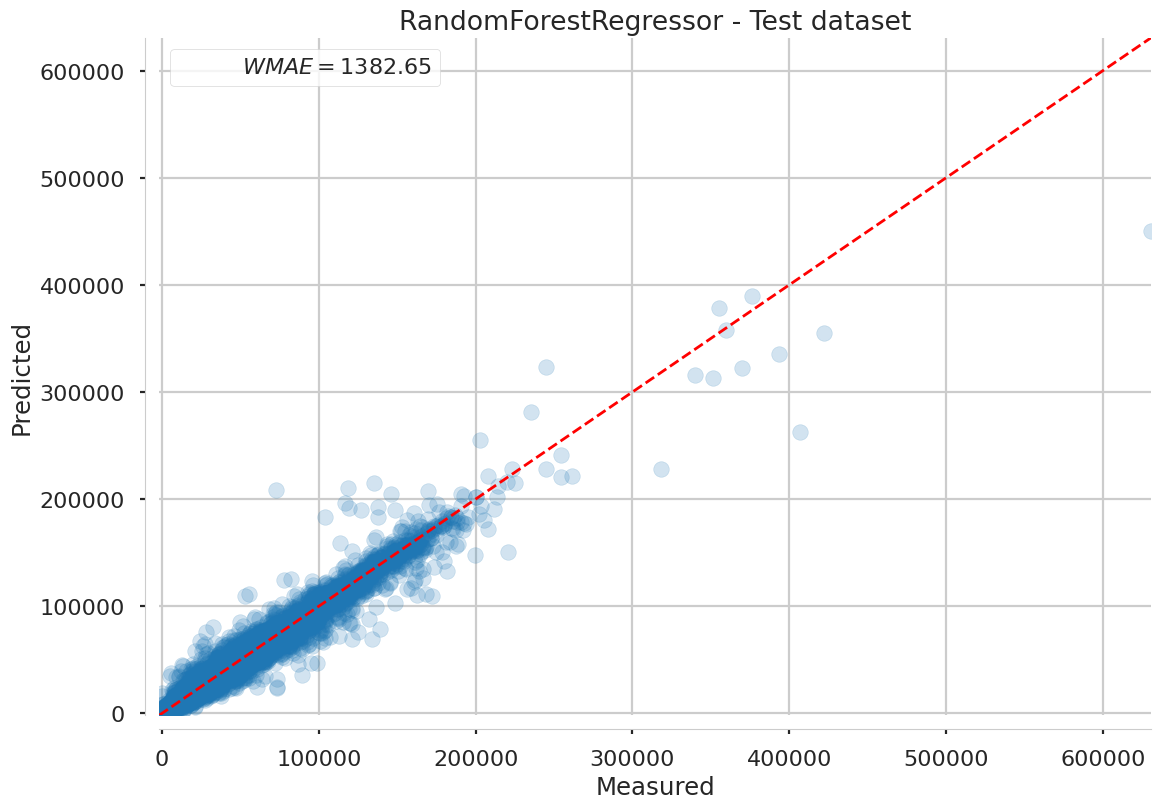

In [393]:
y_pred = best_model_pipeline.predict(X_test)
wmae_metric = WMAE(X_test, y_test, y_pred)

plot_regression_results(
    y_test,
    y_pred,
    f'{best_model} - Test dataset',
    (r'$WMAE ={:.2f}$').format(wmae_metric)
)

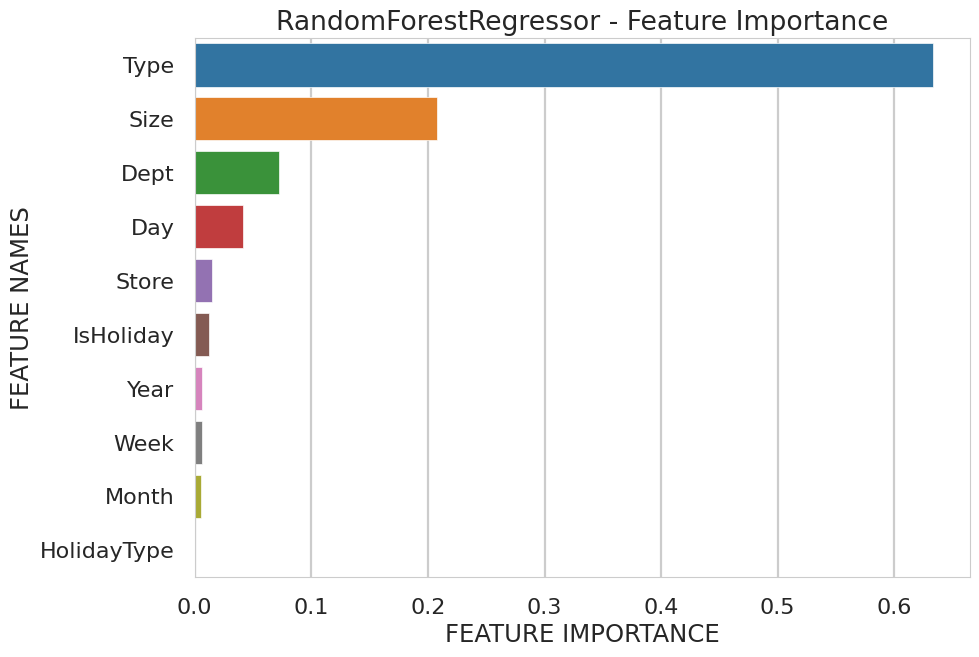

In [394]:
features_importance = best_model_pipeline.steps[1][1].feature_importances_

plot_features_importance(
    features_importance,
    X_test.columns,
    best_model
)

#Testing Our Model

After model training, we can apply the resulting model to the test dataset provided by Walmart.

On this set, we apply our whole model pipeline on this data (Preprocessing + Model) using best_model_pipeline and plot a graph to see our estimation on the test dataset.

In [423]:
features['Date'] = pd.to_datetime(features['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [424]:
# Creates df_test dataset

df_test = pd.merge(features,stores,on='Store',how='left')
df_test = pd.merge(test,df_test,on=['Store', 'Date', 'IsHoliday'],how='left')

df_test['Day']=df_test.Date.dt.day
df_test['Week']=df_test.Date.dt.isocalendar().week
df_test['Month']=df_test.Date.dt.month
df_test['Year']=df_test.Date.dt.year

In [425]:
create_features(df_test)
df_test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Day,Week,Month,Year,HolidayType
0,1.0,1.0,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315.0,2.0,44.0,11.0,2012.0,-1.0
1,1.0,1.0,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315.0,9.0,45.0,11.0,2012.0,-1.0
2,1.0,1.0,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315.0,16.0,46.0,11.0,2012.0,-1.0
3,1.0,1.0,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315.0,23.0,47.0,11.0,2012.0,2.0
4,1.0,1.0,2012-11-30,False,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,A,151315.0,30.0,48.0,11.0,2012.0,-1.0


In [426]:
y_pred = best_model_pipeline.predict(df_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.7s finished


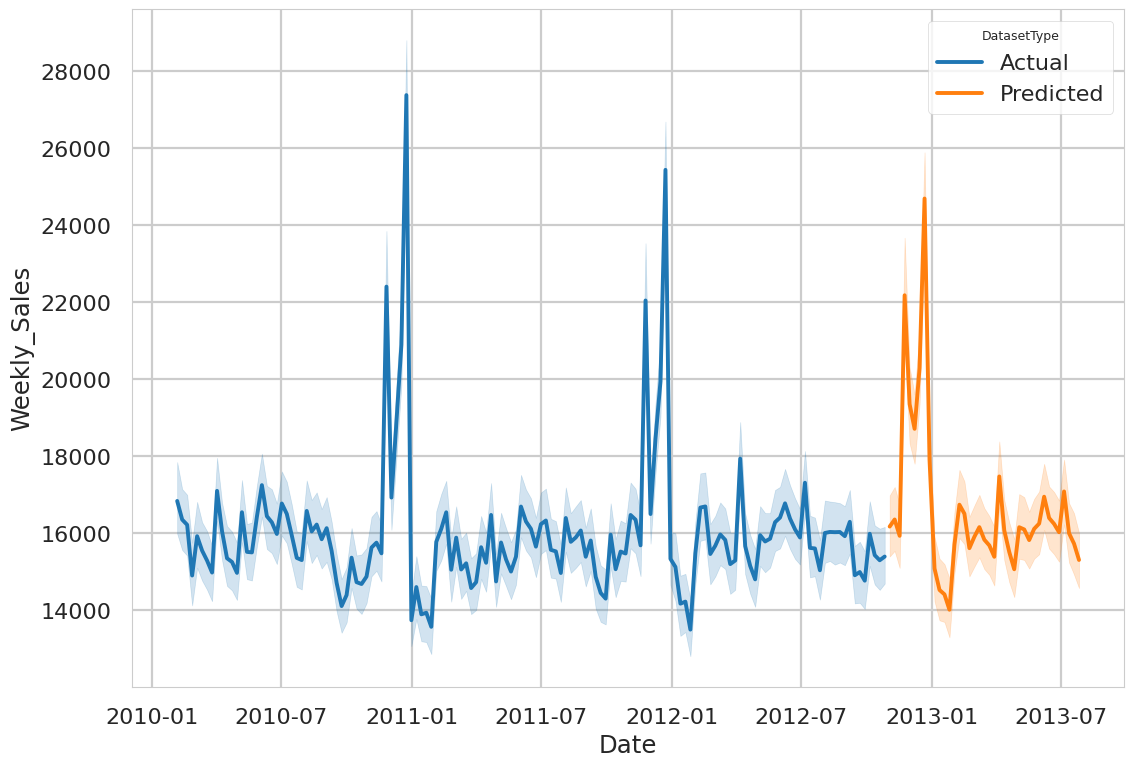

In [427]:
df_test['Weekly_Sales'] = y_pred
df_test['DatasetType'] = 'Predicted'
df_test['Date'] = df_test['Date'].values

df_train['DatasetType'] = 'Actual'
df_train['Date'] = df_train['Date'].values

df_result = df_train.append(df_test)


sns.lineplot(x='Date',
             y=df_result['Weekly_Sales'],
             hue='DatasetType',
             data=df_result)

plt.show()